## Link de GitHub:
https://github.com/jeanpanamito/Itinerario_Datos_Practicas

#### Modelo de Grafo

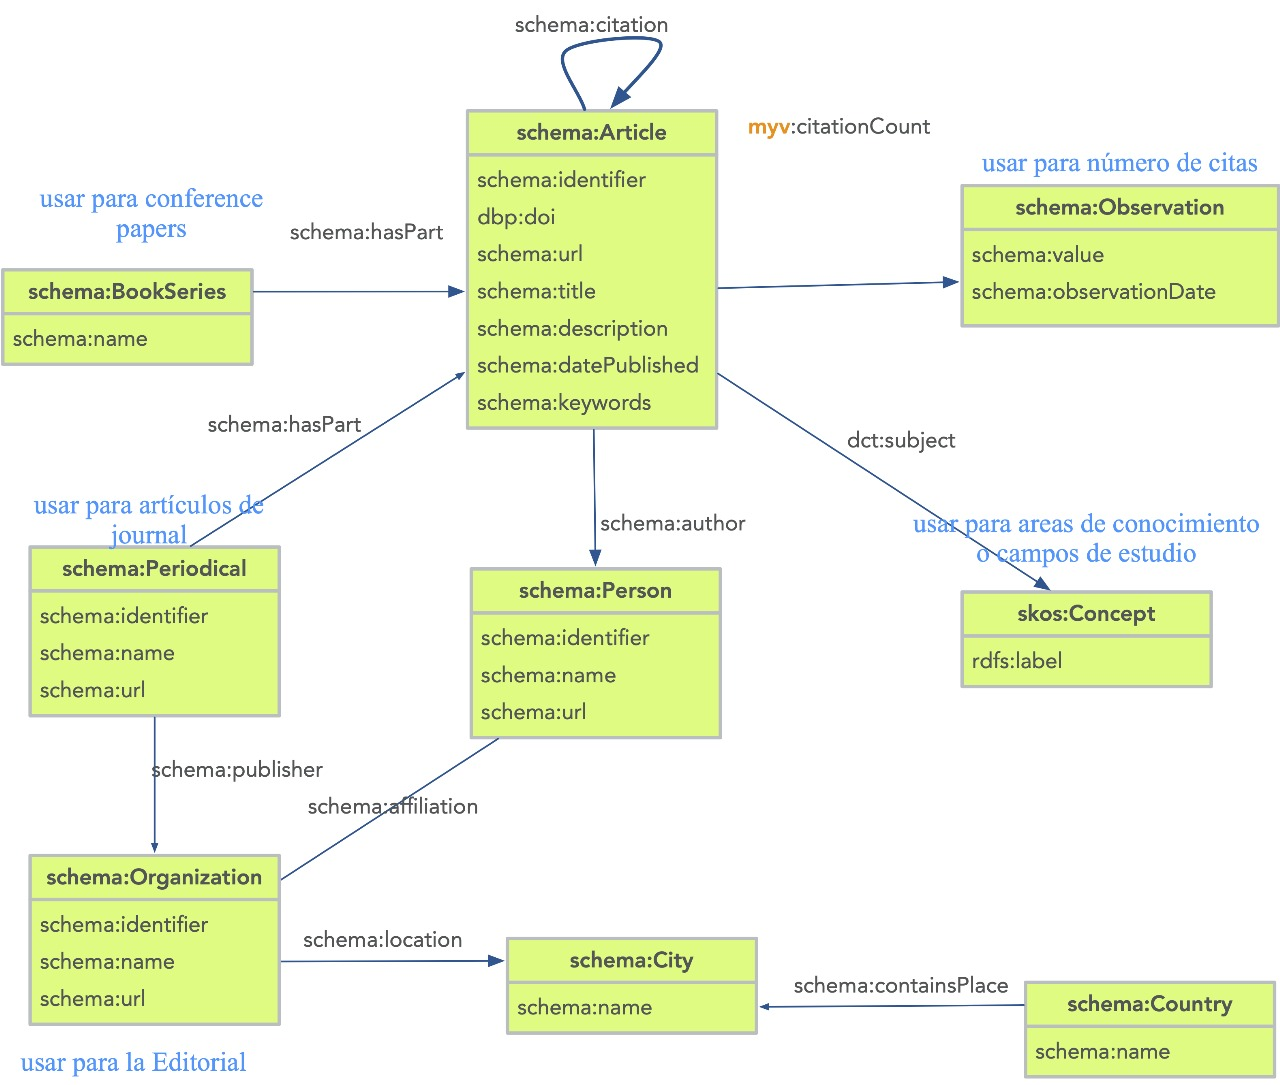

In [2]:
# Retrieve the model as the reference for transformation
from IPython.display import Image

# Specify the path to your image file
image_path = '../Modelo.jpg'

# Display the image
Image(filename=image_path,width=500)

In [2]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD, SKOS, DCTERMS
import pandas as pd
import re

# Helper function to clean and format strings for URIs
def clean_for_uri(text):
    if not text:
        return "unknown"
    a, b = 'áéíóúüñÁÉÍÓÚÜÑ', 'aeiouunAEIOUUN'
    trans = str.maketrans(a, b)
    text = text.translate(trans)
    text = re.sub(r'[<>:"/\\|?*(){}[\].,;\']', '', text)
    text = re.sub(r'\s+', '_', text)
    text = re.sub(r'[^a-zA-Z0-9_-]', '', text)
    return text.lower()[:100]

def clean_for_uri_country(text):
    if not text:
        return "unknown"
    a, b = 'áéíóúüñÁÉÍÓÚÜÑ', 'aeiouunAEIOUUN'
    trans = str.maketrans(a, b)
    text = text.translate(trans)
    text = re.sub(r'[<>:"/\\|?*(){}[\].,;\']', '', text)
    text = re.sub(r'\s+', '_', text)
    text = re.sub(r'[^a-zA-Z0-9_-]', '', text)
    return text.title()[:100]

# Namespaces
g = Graph()
schema = Namespace("https://schema.org/")
dbp = Namespace("http://dbpedia.org/resource/")
myv = Namespace("http://example.org/myv/")
ex = Namespace("http://example.org/sa/")  # Nueva URI base con 'sa'
sko = SKOS
g.bind("schema", schema)
g.bind("dbp", dbp)
g.bind("myv", myv)
g.bind("ex", ex)  # Enlazar la nueva URI base
g.bind("skos", sko)
g.bind("dcterms", DCTERMS)

# Load CSVs
citations_df = pd.read_csv('citations.csv')
datos_con_referencias_df = pd.read_csv('scopus_detailed_papers.csv')
scopus_papers_df = pd.read_csv('scopus_papers.csv')

# Add Countries and Cities
locations = scopus_papers_df[['affiliation_country', 'affiliation_city']].dropna().drop_duplicates()
for _, row in locations.iterrows():
    countries = [country.strip() for country in row['affiliation_country'].split(';')]
    cities = [city.strip() for city in row['affiliation_city'].split(';')]
    for country, city in zip(countries, cities):
        country_uri = URIRef(ex + clean_for_uri_country(country))
        city_uri = URIRef(ex + clean_for_uri_country(city))
        g.add((country_uri, RDF.type, schema.Country))
        g.add((country_uri, schema.name, Literal(country)))
        g.add((city_uri, RDF.type, schema.City))
        g.add((city_uri, schema.name, Literal(city)))
        g.add((city_uri, schema.containsPlace, country_uri))

# Add Organizations and link to cities
organizations = scopus_papers_df[['affilname', 'affiliation_city', 'affiliation_country']].dropna().drop_duplicates()
for _, row in organizations.iterrows():
    org_uri = URIRef(ex + clean_for_uri(row['affilname']))
    cities = [city.strip() for city in row['affiliation_city'].split(';')]
    countries = [country.strip() for country in row['affiliation_country'].split(';')]
    g.add((org_uri, RDF.type, schema.Organization))
    g.add((org_uri, schema.name, Literal(row['affilname'])))
    for city, country in zip(cities, countries):
        city_uri = URIRef(ex + clean_for_uri_country(city))
        country_uri = URIRef(ex + clean_for_uri_country(country))
        g.add((org_uri, schema.location, city_uri))
        g.add((city_uri, schema.containsPlace, country_uri))       

# Add Persons and their Affiliations
for _, row in datos_con_referencias_df[['author_names', 'affilname', 'affiliation_city', 'affiliation_country']].dropna().iterrows():
    authors = row['author_names'].split(';')
    affiliations = row['affilname'].split(';')
    cities = row['affiliation_city'].split(';')
    countries = row['affiliation_country'].split(';')
    
    # Ensure all lists have the same length by truncating or padding with "unknown"
    max_len = max(len(authors), len(affiliations), len(cities), len(countries))
    authors += ["unknown"] * (max_len - len(authors))
    affiliations += ["unknown"] * (max_len - len(affiliations))
    cities += ["unknown"] * (max_len - len(cities))
    countries += ["unknown"] * (max_len - len(countries))
    
    for author, affiliation, city, country in zip(authors, affiliations, cities, countries):
        author_clean = author.strip().replace(',', '')
        # Create URIs for each entity
        author_uri = URIRef(ex + clean_for_uri(author.strip()))
        org_uri = URIRef(ex + clean_for_uri(affiliation.strip()))
        city_uri = URIRef(ex + clean_for_uri_country(city.strip()))
        country_uri = URIRef(ex + clean_for_uri_country(country.strip()))
        
        # Add Person and their affiliation
        g.add((author_uri, RDF.type, schema.Person))
        g.add((author_uri, schema.name, Literal(author_clean.strip())))
        g.add((author_uri, RDFS.label, Literal(author_clean.strip())))
        g.add((author_uri, schema.affiliation, org_uri))
        
        # Add Organization and its location
        g.add((org_uri, RDF.type, schema.Organization))
        g.add((org_uri, schema.name, Literal(affiliation.strip())))
        g.add((org_uri, schema.location, city_uri))
        
        # Add City and its country
        g.add((city_uri, RDF.type, schema.City))
        g.add((city_uri, schema.name, Literal(city.strip())))
        g.add((city_uri, schema.containsPlace, country_uri))
        
        # Add Country
        g.add((country_uri, RDF.type, schema.Country))
        g.add((country_uri, schema.name, Literal(country.strip())))

# Add Keywords
keywords = scopus_papers_df['authkeywords'].dropna().str.split('|').explode().str.strip().str.lower().drop_duplicates()
for keyword in keywords:
    concept_uri = URIRef(ex + clean_for_uri(keyword))  
    g.add((concept_uri, RDF.type, SKOS.Concept))
    g.add((concept_uri, RDFS.label, Literal(keyword))) 

# Add Articles
for _, row in scopus_papers_df.iterrows():
    if pd.isna(row['doi']):
        continue
    article_uri = URIRef(ex + clean_for_uri(row['doi']))  
    g.add((article_uri, RDF.type, schema.Article))
    g.add((article_uri, schema.identifier, Literal(row['doi'])))
    g.add((article_uri, schema.title, Literal(row['title'])))
    if not pd.isna(row['description']):
        g.add((article_uri, schema.description, Literal(row['description'])))
    if not pd.isna(row['coverDate']):
        g.add((article_uri, schema.datePublished, Literal(row['coverDate'], datatype=XSD.date)))
    
    # Reemplazar myv:citationCount por entidad de observación
    if not pd.isna(row['citedby_count']):
        observation_uri = URIRef(ex + clean_for_uri(row['doi'] + "_citation_count"))  
        g.add((observation_uri, RDF.type, myv.Observation))
        g.add((observation_uri, schema.observationDate, Literal("2025-12-21", datatype=XSD.date)))  # Fecha fija
        g.add((observation_uri, schema.value, Literal(row['citedby_count'], datatype=XSD.integer)))
        g.add((article_uri, schema.observation, observation_uri))
    
    if not pd.isna(row['authkeywords']):
        for keyword in row['authkeywords'].split('|'):
            concept_uri = URIRef(ex + clean_for_uri(keyword.strip().lower()))  
            g.add((article_uri, DCTERMS.subject, concept_uri))
            
    if not pd.isna(row['author_names']):
        for author_name in row['author_names'].split(';'):
            author_uri = URIRef(ex + clean_for_uri(author_name.strip()))  
            clean_name = author_name.strip().replace(',', '') # En casos como "Mohammad, Emma" se elimina el caractér ','
            g.add((author_uri, RDF.type, schema.Person))
            g.add((author_uri, schema.name, Literal(clean_name.strip())))
            g.add((author_uri, RDFS.label, Literal(clean_name.strip())))
            g.add((article_uri, schema.author, author_uri))

# Add Citations
for _, row in citations_df.dropna(subset=['DOI', 'Paper DOI']).iterrows():
    source_uri = URIRef(ex + clean_for_uri(row['DOI']))  # Artículo que cita
    target_uri = URIRef(ex + clean_for_uri(row['Paper DOI']))  # Artículo citado

    g.add((source_uri, schema.citation, target_uri))  # Conectar directamente los artículos


# Serialize RDF to Turtle format
g.serialize("articles_base_data.ttl", format="turtle")

<Graph identifier=Nc99c6e27c5f9416cb10d359beeaf9c93 (<class 'rdflib.graph.Graph'>)>

In [3]:
!jupyter nbconvert --to html generacion_grafo_final.ipynb

[NbConvertApp] Converting notebook generacion_grafo_final.ipynb to html
[NbConvertApp] Writing 314633 bytes to generacion_grafo_final.html
